## Findings
  * general
    * batch size should be at least 1x(number of classes) in order to take advantage of MTL
    * Always start training a model with dropout=ker_reg=act_reg=0, look at bias and variance then add until good fit
    * No pooling gives very fast results but strong overfitting and large model size
    * Don't worry about class weights unless heavily (20x or more) imbalanced
    * head:0x** works best, any more layers underfits
    * training with dropout makes val_loss very noisy and auto saving doesn't work well, enable regular saving
    * Don't use both Dropout and Batch Norm together (if you do use very small dropout, https://arxiv.org/pdf/1801.05134.pdf)
    
  * multi-label output
    * sigmoid output makes model very sensitive to learning_rate.
      * I have found with VGG16 around 5e-5 is a good start
      * Use eg setup_callbacks(hist=2, grads=True) to enable gradient outputs; check if class_logits_out is becoming spread between 0 and 1, check that gradients are not 0 (should be around 1e-3).
  * single-label output
    * Pretty stable with any architecture
    

## Bugs
  * There may be a GPU memory leak somewhere... keras does not recycle models properly. I'll try to find this.

In [18]:
%matplotlib notebook

from collections import Counter
from itertools import cycle
import json
import os
import pickle
import re
import sys
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ['LD_LIBRARY_PATH']
from abyss_deep_learning.utils import config_gpu


from imgaug import augmenters as iaa
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.applications.vgg16 import VGG16
import keras.backend as K
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard, EarlyStopping, LearningRateScheduler, Callback, TerminateOnNaN
from keras.layers import (
    Flatten, GlobalAveragePooling2D, GlobalMaxPooling2D, Input, Dense, Dropout, Activation)
from keras.layers.normalization import BatchNormalization
from keras.models import Model
import keras.layers as layers
import keras.initializers
from abyss_deep_learning.keras.activations import Hexpo
from keras.layers.advanced_activations import PReLU
from keras.regularizers import l1_l2
from keras.metrics import binary_accuracy, categorical_accuracy
from pycocotools.coco import COCO
from skimage.transform import resize
from sklearn.metrics import precision_recall_curve, average_precision_score
import keras.initializers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
tf = K.tf
from sklearn.utils.class_weight import compute_class_weight

from abyss_deep_learning.keras.classification import set_to_multihot

from abyss_deep_learning.utils import balanced_set
from abyss_deep_learning.keras.classification import (
    ClassificationDataset, PRTensorBoard, Inference,
    caption_map_gen, multihot_gen, augmentation_gen, skip_bg_gen, cached_gen)
from abyss_deep_learning.keras.utils import (
    batching_gen, lambda_gen, calc_class_weights, count_labels_multi, count_labels_single, gen_dump_data)
import abyss_deep_learning.abyss_dataset as dataset_model

config_gpu([1, 0])

# JSON Prep

In [19]:
# from abyss_deep_learning.utils import instance_to_caption
# for file in [
#             os.path.join(database_dir, dataset_name, "train.json"),
#             os.path.join(database_dir, dataset_name, "val.json"),
#         ]:
#     db = instance_to_caption(json.load(open(file,"r")))
#     with open(file + ".2","w") as f:
#         json.dump(db, f)

# Setup Data

In [44]:
############### CONFIGURE ALL VARIABLES IN THIS CELL ########################
# num_classes assumed from caption_map entries
image_dims = (480, 640, 3) # What to resize images to before CNN
NN_DTYPE = np.float32 # Pretrained networks are in float32

# Caption type can be either "single" or "multi". This sets up various other parameters in the system.
caption_type = "multi" 
use_balanced_set = False
use_cached = True
aug_config = None # Uncomment bottom of cell to add augmentation
use_class_weights = True

ignore_sometimes = ['F', 'SJ', 'SO', 'IP', 'ED']
ignore_captions = set(['JO', 'RI', 'U', 'X', 'C'] + ignore_sometimes)
captions = set(["C", "ED", "F", "IP", "JD", "SJ", "SO", "U", "X"]) - ignore_captions


# aug_config = {
#     'flip_lr_percentage': 0.5,
#     'flip_ud_percentage': 0.5,
#     'affine': {
#         "order": 1,
#         'scale': {
#             "x": (0.8, 1.2),
#             "y": (0.8, 1.2)
#         },
#         "rotate": (-10, 10),
#         "shear": (-5, 5),
#         "mode": 'constant'
#     },
#     'color': {
#         'probability': 0.9,
#         'hue': (-25, 25),
#         'saturation': (25, 25),
#         'value': (-25, -25)
#     }
# }

In [45]:
caption_map = {k: v for v, k in enumerate(sorted(captions))}
print(caption_map)
caption_map_r = {val: key for key, val in caption_map.items()}
num_classes = len(caption_map)
print("Number of classes:", num_classes)

# Import or define the right translator
from abyss_deep_learning.datasets.translators import AbyssCaptionTranslator, CloudFactoryCaptionTranslator
translator = AbyssCaptionTranslator()

database_dir = "/data/abyss/projectmax/feature-detection/large-fromCF"
dataset_name = "alltogether/unique"
'/data/ab'
dataset_files = {
    'train': os.path.join(database_dir, "{:s}/train.json".format(dataset_name)),
    'val': os.path.join(database_dir, "{:s}/val.json".format(dataset_name)),
    'test': os.path.join(database_dir, "{:s}/test.json".format(dataset_name))
}
dataset_name = dataset_name.replace("/", "-")

{'JD': 0}
Number of classes: 1


# Setup pre/post processing

In [46]:
### CONFIG THIS
def augmentation_gen(gen, aug_config, enable=True):
    '''
    Data augmentation for classification task.
    Target is untouched.
    '''
    if not enable:
        while True:
            yield from gen
    aug_list = []
    if 'flip_lr_percentage' in aug_config:
        aug_list += [iaa.Fliplr(aug_config['flip_lr_percentage'])]
    if 'flip_ud_percentage' in aug_config:
        aug_list += [iaa.Flipud(aug_config['flip_ud_percentage'])]
    if 'affine' in aug_config:
        aug_list += [iaa.Affine(**aug_config['affine'])]
    if 'color' in aug_config:
        aug_list += [
            iaa.Sometimes(
                aug_config['color']['probability'],
                iaa.Sequential([
                    iaa.ChangeColorspace(from_colorspace="RGB", to_colorspace="HSV"),
                    iaa.WithChannels(0, iaa.Add(aug_config['color']['hue'])),
                    iaa.WithChannels(1, iaa.Add(aug_config['color']['saturation'])),
                    iaa.WithChannels(2, iaa.Add(aug_config['color']['value'])),
                    iaa.ChangeColorspace(from_colorspace="HSV", to_colorspace="RGB")
        ]))]
    if 'custom' in aug_config:
        aug_list += aug_config['custom']
    seq = iaa.Sequential(aug_list)
    for image, target in gen:
        yield seq.augment_image(image), target
        
def preprocess(image, caption):
    image = resize(image, image_dims, preserve_range=True, mode='constant')
    return preprocess_input(image.astype(NN_DTYPE), mode='tf'), caption

def postprocess(image):
    return ((image + 1) * 127.5).astype(np.uint8)
     
def pipeline(gen, num_classes, aug_config=None):
    return (
        lambda_gen(
            augmentation_gen(
                skip_bg_gen(
                    multihot_gen(
                        caption_map_gen(gen, caption_map)
                    , num_classes=num_classes)
                )
            , aug_config, enable=(aug_config is not None))
        , func=preprocess)
    )



In [47]:
import concurrent.futures

dataset = {
    'names': list(dataset_files.keys()),
    'classes': sorted(list(caption_map.values())),
    'class_weights': {},
    'ids' : {},
    'gens': {},
    'data': {},
    'coco': {}
}
print("Combinations of labels present")


for name, path in dataset_files.items():
    coco = ClassificationDataset(caption_map, translator, path)
    ids = list(balanced_set(coco)) if use_balanced_set else [img['id'] for img in coco.imgs.values()]
#     if name in ['test']:
#         ids = ids[::4] #TODO: REMOVE AFTER TESTING
#     if name in ['train']:
#         ids = ids[::2] #TODO: REMOVE AFTER TESTING
    gen = pipeline(
        coco.generator(imgIds=ids, shuffle_ids=True),
        num_classes, aug_config if name == 'train' else None)
    print("{:s}: {:d} images".format(name, len(ids)))
    print(set([tuple(coco.load_caption(image['id'])) for image in coco.imgs.values() if image['id'] in ids]))
    
    print("{:s} set size {:d}".format(name, len(ids)))
    
    dataset['coco'][name] = coco
    dataset['ids'][name] = ids
    dataset['gens'][name] = gen
    if use_cached:
        expected_size = 4 * len(ids) * np.product(image_dims)
        print("Caching {:s} set will take {:.1f} GB".format(name, expected_size / 1024 ** 3))
        dataset['data'][name] = [
            np.zeros((len(ids),) + image_dims, dtype=np.float32),
            np.zeros((len(ids), num_classes), dtype=np.float32)]
        
#         dataset['data'][name] = gen_dump_data(gen, len(ids))
        def procedure(a):
            idx, img_id = a
            image, caption = preprocess(coco.load_image(img_id), coco.load_caption(img_id))
            caption = set_to_multihot({caption_map[i] for i in caption if i in captions}, num_classes)
            return idx, img_id, image, caption
        
        with concurrent.futures.ProcessPoolExecutor() as executor:
            for idx, img_id, image, caption in executor.map(procedure, enumerate(ids)):
                dataset['data'][name][0][idx] = image
                dataset['data'][name][1][idx] = np.array(caption)
        print("Dataset {:s} has {:d} classes".format(name, np.count_nonzero(dataset['data'][name][1].sum(axis=0))))
    

def data_source(name):
    if dataset['data'] and name in dataset['data']:
        return dataset['data'][name]
    return dataset['gens'][name]

def data_sample(name, size=None):
    source = data_source(name)
    if isinstance(source, list):
        if dataset['data'][name]:
            idx = np.random.choice(np.arange(dataset['data'][name][0].shape[0]), size=size)
            images = dataset['data'][name][0][idx]
            labels = dataset['data'][name][1][idx]
#             if size == None:
#                 images, labels = images[0], labels[0]
            return images, labels
    for image, label in source:
        return image, label
# print(np.unique(
#     [i 
#      for image in coco_train.imgs.values()
#     for i in coco_train.load_caption(image['id'])]
# ))

Combinations of labels present
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
val: 34 images
{('ED', 'JD', 'F', 'IP'), ('ED', 'SJ', 'IP'), ('SJ', 'IP'), ('ED', 'F'), ('ED', 'C', 'F', 'IP'), ('ED', 'X', 'F', 'IP'), ('SO', 'X'), ('F', 'IP'), ('SJ', 'C', 'IP'), ('SJ', 'C'), ('JD', 'X', 'F', 'IP'), ('U', 'X'), ('SJ', 'F'), ('ED', 'F', 'IP'), ('JD', 'C', 'F', 'IP'), ('SJ', 'JO', 'IP'), ('JD', 'F', 'IP')}
val set size 34
Caching val set will take 0.1 GB
Dataset val has 1 classes
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
test: 127 images
{('SJ', 'IP'), ('RI', 'F', 'X'), ('JD', 'F'), ('ED', 'SO', 'IP'), ('background',), ('ED', 'SJ', 'IP', 'JD'), ('F', 'IP'), ('ED', 'F', 'IP'), ('ED', 'SJ', 'C', 'X', 'IP'), ('JD', 'F', 'X'), ('ED', 'RI', 'IP', 'SO'), ('ED', 'RI', 'F', 'IP', 'X'), ('ED', 'SJ', 'X'), ('SJ', 'X', 'IP'), ('ED', 'SJ', 'X', 'IP'), ('SJ', 'C', 'IP'), ('ED', 'SO', 'X', 'IP'), ('U', 'C', 'IP', 'ED'), ('SJ', 'X'

In [48]:
# %%timeit -n1 -r1
image, target = data_sample('train', 10)
if np.sum(target) == 0:
    print("BG")
else:
    print(image.shape)
    print(target)

(10, 480, 640, 3)
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]]


<IPython.core.display.Javascript object>


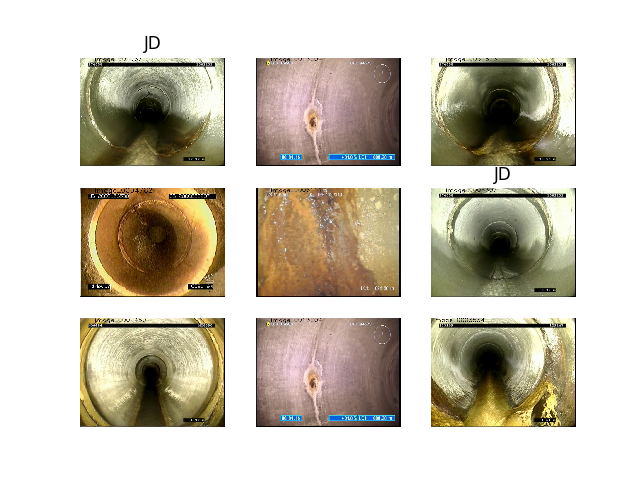

Left to right: ground truth samples from float32 (480, 640, 3)
val, float32 (480, 640, 3)
test, float32 (480, 640, 3)
train, float32 (480, 640, 3)
val, float32 (480, 640, 3)
test, float32 (480, 640, 3)
train, float32 (480, 640, 3)
val, float32 (480, 640, 3)
test, float32 (480, 640, 3)
train, 

In [59]:
plt.figure()
num_rows = 3
print("Left to right: ground truth samples from ", end='')
for j in range(num_rows):
    for i, name in enumerate(dataset['names']):
        plt.subplot(num_rows, 3, 3 * j + i + 1)
    #     print(data[0].shape, data[1], (np.min(data[0]), np.max(data[0])))
        image, label = data_sample(name, None)
        print(image.dtype, image.shape)
        plt.imshow(postprocess(image))
        plt.title(', '.join([caption_map_r[int(cap_id)] for cap_id in np.argwhere(label)]))
        print(name, end=', ')
        plt.axis('off')


In [9]:
# This cell intentionally left blank due to display bug above.

In [10]:
###################
def label_encoding(y, mode):
    if mode == 'multihot':
        return np.argwhere(y)[:, 1]
    else:
        raise NotImplementedError()
    #   return np.sum(y * (2 ** np.arange(y.shape[1])[::-1]), axis=1)

def noop(args, **kwargs):
    return args
    
if use_class_weights:
    for name, coco in dataset['coco'].items():
        print("{:s} {:s} class stats {:s}".format('=' * 8, name, '=' * 8))
        labels = [coco.load_caption(image['id'])
                  for image in coco.imgs.values() if image['id'] in dataset['ids'][name]]
        y = [caption_map[l]
            for fields in labels for l in fields if l in captions]
#         print(y)
        count = np.array(list(dict(sorted(Counter(y).items(), key=lambda x: x[0])).values()))
        spread = {i: float(v.round(2)) for i, v in enumerate(count / np.sum(count))}
        class_weights = compute_class_weight('balanced', dataset['classes'], y)
        class_weights = {i: float(np.round(v, 3)) for i, v in enumerate(class_weights)}
        dataset['class_weights'][name] = class_weights
        a = np.array(list(dataset['class_weights'][name].values()))
        
        print("class weights:".format(name))
        print(" ", class_weights)
        trivial = np.mean(a / np.max(a))
        print("trivial result accuracy:\n  {:.2f} or {:.2f}".format(trivial, 1-trivial))
        print("class cover fractions:\n  ", spread )


======== val class stats ========
class weights:
  {0: 1.0}
trivial result accuracy:
  1.00 or 0.00
class cover fractions:
   {0: 1.0}
======== test class stats ========
class weights:
  {0: 1.0}
trivial result accuracy:
  1.00 or 0.00
class cover fractions:
   {0: 1.0}
======== train class stats ========
class weights:
  {0: 1.0}
trivial result accuracy:
  1.00 or 0.00
class cover fractions:
   {0: 1.0}


# Setup model

In [11]:
def add_model_regularization(model, kernel_regularizer_l2, activity_regularizer_l1):
#     # Add L2 Regularization
#     # Skip gamma and beta weights of batch normalization layers.
#     if kernel_regularizer_l2:
#         reg_losses = [
#             keras.regularizers.l2(kernel_regularizer_l2)(w) / tf.cast(tf.size(w), tf.float32)
#             for w in model.trainable_weights
#             if not any([l in w.name for l in ['gamma', 'beta']])]
#         model.add_loss(tf.add_n(reg_losses, name='l2_reg_loss'))
#     if activity_regularizer_l1:
#         reg_losses = [
#             keras.regularizers.l1(activity_regularizer_l1)(
#                 layer.get_output_at(0)) / tf.cast(tf.size(layer.get_output_at(0)), tf.float32)
#             for layer in model.layers
#             if layer.trainable and not any([l in layer.name for l in ['class_logits', 'batch_norm']])]
#         model.add_loss(tf.add_n(reg_losses, name='l1_reg_loss'))
    for layer in model.layers: #Save 
        if not layer.trainable or 'batch_norm' in layer.name or 'logits' in layer.name:
            continue
        if hasattr(layer, 'kernel_regularizer') and kernel_regularizer_l2:
            if 'kernel' in layer.weights[0].name:
                size = np.product(layer.weights[0].shape.as_list())
                if size:
                    layer.kernel_regularizer = l1_l2(0, kernel_regularizer_l2 / size)
        if hasattr(layer, 'activity_regularizer') and activity_regularizer_l1:
            size = np.product(layer.get_output_shape_at(0)[1:])
            if size:
                layer.activity_regularizer = l1_l2(activity_regularizer_l1 / size, 0)
            
    # Suspect this is where GPU memory leak is coming from
    model_config = model.get_config()
    model_weights = model.get_weights()
    model = None
    K.clear_session()
    model = Model.from_config(model_config)
    model.set_weights(model_weights)
    return model
    
def create_new_head(base_model, model_params, add_reg=False):
    '''make sure base_model has include_top=False. If loss=None then it is determined.'''
    if model_params.activation == None:
        if model_params.caption_type == "single":
            model_params.activation = "softmax" 
        else:
            model_params.activation = "sigmoid"

    x = base_model.output
    if model_params.pool == 'avg':
        x = GlobalAveragePooling2D()(x)
    elif model_params.pool == 'max':
        x = GlobalMaxPooling2D()(x)
    else:
        x = Flatten()(x)

#     x = BatchNormalization()(x)
    if model_params.dropout:
        x = Dropout(model_params.dropout)(x)

    for i in range(model_params.num_hidden_layers):
        x = Dense(model_params.num_hidden_neurons)(x)
#         x = BatchNormalization()(x)
#         x = Activation('relu')(x)
        x = PReLU()(x) # layer_depth=(4+i)
        if model_params.dropout:
            x = Dropout(model_params.dropout)(x)

    predictions = Dense(
        model_params.num_classes,
        activation=model_params.activation,
        kernel_initializer='uniform',
#         bias_initializer=keras.initializers.he_uniform(),
        name='class_logits')(x)

    for layer in base_model.layers:
        layer.trainable = model_params.train_features
    model = Model(inputs=base_model.input, outputs=predictions)
    if add_reg:
        model = add_model_regularization(
            model, 
            model_params.kernel_regularizer_l2,
            model_params.activity_regularizer_l1)
    return model

# Model selection and training
You may have to change these callbacks to suit the dataset and model
Note that calculating gradients and histogram on large layered networks (resnet and inception) takes a long time (5 minutes per epoch calculated) so you may only want to do this infrequently or not at all.

In [12]:
def simple_model_factory(depth, activity_reg_l1=0, kernel_reg_l2=0):
    model_name = 'simple-{:d}'.format(depth)
    def function(include_top=False, weights=None, input_shape=None):
        def unit(x, filters, conv=3, stride=1, layer_depth=None):
            layer_no = str(layer_depth if layer_depth is not None else '')
            for i, s in enumerate([stride, stride, stride + 1]):
                x = layers.Conv2D(
                    filters, (conv, conv),
                    strides=(s, s),
                    padding='same',
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l1_l2(0, kernel_reg_l2),
                    name='layer{:s}_conv{:d}'.format(layer_no, i))(x)
#                 x = layers.BatchNormalization(
#                     name='layer{:s}_batch_norm{:d}'.format(layer_no, i))(x)
                if activity_reg_l1:
                    size = np.product(x.shape.as_list()[1:])
                    reg = {"activity_regularizer": l1_l2(activity_reg_l1 / size, 0)}
#                 act = PReLU(shared_axes=[1, 2])
                act = Hexpo(layer_depth, shared_axes=[1, 2]) #layers.Activation('relu')
                if activity_reg_l1:
                    size = np.product(x.shape.as_list()[1:])
                    act.activity_regularizer = l1_l2((activity_reg_l1 / size), 0)
                x = act(x)
            return x

        img_input = layers.Input(shape=input_shape)
        x = img_input
        for i in range(depth):
            x = unit(x, 2 ** (6 + i), conv=3, stride=1, layer_depth=(i))
        return Model(img_input, x, name=model_name)
    setattr(function, '__name__', model_name)
    return function

In [13]:
# Modify this class to change search parameters
class Experiment(object):
    def __init__(self, data_name, input_shape):
        self.callbacks = None
        self.history = dict()
        self.data_name = data_name
        self.num_classes = num_classes
        self.caption_type = caption_type
        self.model = None
        self.model2 = None
        self.input_shape = input_shape
        self.batch_size = num_classes
        self.id = str(np.random.randint(0, 9999))
        if self.caption_type == 'single':
            self.activation = 'softmax'
            self.loss = 'categorical_crossentropy'
        else:
            self.activation = 'sigmoid'
            self.loss = 'binary_crossentropy'
            
        self.feature_extractor = VGG16
        self.model_name = self.feature_extractor.__name__
        self.learning_rate = 5e-5
        self.dropout = None
        self.train_features = True
        self.pool = 'avg'
        self.num_hidden_layers = 0
        self.num_hidden_neurons = 0
        self.pretrained_weights = 'imagenet'
        self.class_weights = None
        self.kernel_regularizer_l2 = None
        self.activity_regularizer_l1 = None

    def random_init(self):
        # Modify this for parameter search
        self.feature_extractor = np.random.choice([VGG16, ResNet50, InceptionV3])
        self.model_name = self.feature_extractor.__name__
        self.learning_rate = 10 ** np.random.uniform(-5, -3)
        self.dropout = np.random.uniform(0.0, 0.5)
        self.kernel_regularizer_l2 = 10 ** np.random.uniform(-5, -2)
        self.activity_regularizer_l1 = 10 ** np.random.uniform(-5, -2)
                
    
    def serialize(self):
        self.model_name = self.feature_extractor.__name__
        return ' '.join([
            ':'.join([key, str(value)]) 
            for key, value in [
                ("ID", self.id),
                ("DS", self.data_name),
                ("BS", self.batch_size),
                ("AC", self.activation),
                ("MO", self.model_name),
                ("HE", "{:d}x{:d}".format(self.num_hidden_layers, self.num_hidden_neurons)),
                ("TR", 'all' if self.train_features else 'heads'),
                ("FT", str(self.pretrained_weights)),
                ("LF", self.loss.__name__ if callable(self.loss) else str(self.loss)),
                ("LR", "{:.1e}".format(self.learning_rate)),
                ("AR", "{:.1e}".format(self.activity_regularizer_l1 or 0)),
                ("KR", "{:.1e}".format(self.kernel_regularizer_l2 or 0)),
                ("DO", "{:.2f}".format(self.dropout or 0)),
                ("PO", str(self.pool)),
                ("CW", str(None) \
                           if self.class_weights is None\
                           else ','.join(["{:d}={:.2f}".format(k, v) for k, v in self.class_weights.items()]))
            ]])
    
    def deserialize(self, string):
        strs = dict(([tuple(field.split(':')) for field in string.split(' ') if len(field.split(':')) == 2]))
        self.id = strs['ID']
        self.model_name = strs['MO']
        self.batch_size = int(strs['BS'])
        self.num_hidden_layers, self.num_hidden_neurons = [int(s) for s in strs['HE'].split('x')]
        self.train_features = strs['TR'] == 'all'
        self.pretrained_weights = None if strs['FT'] == 'None' else strs['FT']
        self.activation = strs['AC']
        self.loss = strs['LF']
        self.learning_rate = float(strs['LR'])
        self.activity_regularizer_l1 = float(strs['KR'])
        self.kernel_regularizer_l2 = float(strs['AR'])
        self.dropout = float(strs['DO'])
        self.pool = strs['PO']
        if strs['CW'].lower() in ['none', 'false', '0']:
            self.class_weights = None
        else:
            self.class_weights = {
                int(field.split('=')[0]): float(field.split('=')[1])
                for field in strs['CW'].split(',')
            }
        model_map = {
            'VGG16': VGG16,
            'ResNet50': ResNet50,
            'InceptionV3': InceptionV3,
        }
        if strs['MO'].startswith('simple,'):
            fields = strs['MO'].split(',')[1:]
            model_map[strs['MO']] = simple_model_factory(int(fields[0]), float(fields[1]), float(fields[2]))
        self.feature_extractor = model_map[strs['MO']]
    
    def describe(self):
        return self.serialize().replace(' ', "\n").replace(":", ": ")
    
    def make_model(self, weights=None, parallel=False):
        self.model = None
        K.clear_session()
        add_reg = 'simple' not in self.model_name
        self.model = create_new_head(
            self.feature_extractor(
                include_top=False,
                weights=self.pretrained_weights,
                input_shape=self.input_shape),
            self, add_reg=add_reg
        )
        if weights:
            self.model.set_weights(weights)
        else:
            freeze = []
            if self.pretrained_weights is None:
                transfer_vgg(self.model)
                freeze = [layer.name for layer in self.model.layers if 'conv' in layer.name.lower()][0:1]
            elif self.pretrained_weights == 'imagenet':
                if self.feature_extractor.__name__ =='VGG16':
                    freeze = [layer.name for layer in self.model.layers if 'conv' in layer.name.lower()][0:3]
                elif self.feature_extractor.__name__ =='ResNet50':
                    freeze = [layer.name for layer in self.model.layers if 'conv' in layer.name.lower()][0:3]
                elif self.feature_extractor.__name__ =='InceptionV3':
                    freeze = [layer.name for layer in self.model.layers if 'conv' in layer.name.lower()][0:3]
            for name in freeze:
                layer = self.model.get_layer(name=name)
                print("locking", layer.name)
                layer.trainable = False
        if parallel:
            from keras.utils import multi_gpu_model
            self.model2 = multi_gpu_model(self.model, gpus=2)#, cpu_merge=True, cpu_relocation=False)            
    
    def get_train_model(self):
        return self.model2 or self.model
            
    def compile_model(self, opt_params=None):
        if not opt_params:
            opt_params={'optimizer': 'nadam'}
        opt_params['loss'] = self.loss
        self.get_train_model().compile(**opt_params, metrics=['binary_accuracy', 'categorical_accuracy'])
        
    def set_logdir(self, logdir):
        self.log_dir = logdir
        self.model_def_path = os.path.join(log_dir, "model_def.json")
        self.model_weights_path = os.path.join(log_dir, "model_weights.h5")
        self.model_info_path = os.path.join(log_dir, "model.json")
        self.model_plot_path = os.path.join(log_dir, "precision-recall.png")
        
    def setup_callbacks(self, schedule=None, hist=False, grads=False):
        models_dir = os.path.join(self.log_dir, "models")
        !mkdir -p "$models_dir"
        best_path = os.path.join(models_dir, "best.{epoch:03d}-{val_loss:.4f}.h5")
        self.callbacks = [
            TerminateOnNaN(),
            ModelCheckpoint(
                best_path, monitor='val_loss', verbose=1,
                save_best_only=True, save_weights_only=True, mode='auto', period=1),
            PRTensorBoard(
                log_dir=self.log_dir, 
                histogram_freq=(hist or 0),
                batch_size=10,
                write_graph=False,
                write_grads=grads,
                write_images=False),
                EarlyStopping(
                    monitor='val_loss', min_delta=0.0, patience=50, verbose=1, mode='auto'),
    #         clr_callback.CyclicLR(base_lr=1e-4, max_lr=0.1, min_lr=0.01, step_size=(2*steps_per_epoch))
            
        ]
        if schedule:
            self.callbacks.append(schedule)

    def go(self, epochs, initial_epoch=0, val_data=None):
        steps_per_epoch = len(dataset['ids']['train']) // self.batch_size
        steps_per_epoch_val = 100 // self.batch_size #len(dataset['ids']['val']) // batch_size
        print("Steps per epoch:", steps_per_epoch)
        print("Steps per steps_per_epoch_val:", steps_per_epoch_val)

        source = data_source('train')
        common = {
            "class_weight": dataset['class_weights']['train'],
            "callbacks": self.callbacks,
            "epochs": epochs,
            "verbose": 1,
            "initial_epoch": initial_epoch,
#             "steps_per_epoch": steps_per_epoch
        }
        if isinstance(source, list): # Cached data
            print("Training cached data")
            self.history = self.get_train_model().fit(
                x=source[0], y=source[1],
                batch_size=self.batch_size,
                validation_data=tuple(data_source('val')),
                shuffle=True,
                **common)
        elif val_data:
            # Generator training with static val data
            self.history = self.get_train_model().fit_generator(
                batching_gen(source, batch_size=exp.batch_size),
                steps_per_epoch=steps_per_epoch,
                validation_steps=steps_per_epoch_val,
                validation_data=val_data,
                workers=10,
                **common)
        else:
            self.history = self.get_train_model().fit_generator(
                batching_gen(source, batch_size=exp.batch_size),
                validation_data=batching_gen(
                    data_source('val'), batch_size=exp.batch_size),
                steps_per_epoch=steps_per_epoch,
                validation_steps=steps_per_epoch_val,
                workers=10,
                **common)
        return self.history

    def evaluate_model(self, test_data, thresh=0.5):
        def multi_label_decision(y_true, y_pred):
            return (y_true > thresh) == (y_pred > thresh)
        def single_label_decision(y_true, y_pred):
            return np.argmax(y_true, axis=-1) == np.argmax(y_pred, axis=-1)
        decision_function = single_label_decision if caption_type == 'single' else multi_label_decision

        Y_true = test_data[1]
        Y_pred = self.get_train_model().predict(test_data[0])
        TP = decision_function(Y_true, Y_pred)
        acc = np.count_nonzero(TP) / TP.size

        print("Test using {:d} samples:".format(len(test_data[0])))
        print("accuracy", acc)
        return Y_true, Y_pred, TP
    

    def save_model(
            self, class_map_r, prediction_type,
            test_metrics=None, description=""):
        from abyss.utils import JsonNumpyEncoder
        def merged(a, b):
            merged = dict(a)
            merged.update(b)
            return merged

        model_info = {
            "name": self.serialize(),
            "description": description,
            "weights": self.model_weights_path,
            "prediction_type": caption_type,
            "model": self.model_def_path,
            "classes": class_map_r,
            "architecture": {
                "backbone": "inceptionv3", # TODO IMPORTANT
                "logit_activation": self.model.get_layer("class_logits").activation.__name__,
                "input_shape": self.input_shape
            }

        }
        if self.history:
            model_info['metrics'] = {
                "loss_function": str(self.history.model.loss),
                "train": merged(
                    self.history,
                    {
                        "epoch": self.history.epoch,
                        "params": self.history.params
                    })
            }
            if test_metrics:
                model_info['metrics']['test'] = test_metrics

        print("Writing model def to " + self.model_def_path)
        with open(self.model_def_path, "w") as file:
            file.write(self.model.to_json())

        print("Writing model weights to " + self.model_weights_path)
        self.model.save_weights(self.model_weights_path)

        print("Writing model info to " + self.model_info_path)
        with open(self.model_info_path, "w") as file:
            file.write(json.dumps(model_info, cls=JsonNumpyEncoder))

    
    def display_performance(self, Y_true, Y_pred, TP):
        precision = dict()
        recall = dict()
        average_precision = dict()
        for i in range(self.num_classes):
            precision[i], recall[i], _ = precision_recall_curve(Y_true[:, i],
                                                                Y_pred[:, i])
            average_precision[i] = average_precision_score(Y_true[:, i], Y_pred[:, i])

        # A "micro-average": quantifying score on all classes jointly
        precision["micro"], recall["micro"], _ = precision_recall_curve(Y_true.ravel(),
            Y_pred.ravel())
        average_precision["micro"] = average_precision_score(Y_true, Y_pred,
                                                             average="micro")
        print('Average precision score, micro-averaged over all classes: {0:0.2f}'
              .format(average_precision["micro"]))

        z = np.all((Y_pred > 0.5) == Y_true, axis=1)
        acc = np.count_nonzero(z) / z.size
        print("exact accuracy", acc)
        z = ((Y_pred > 0.5) == Y_true)
        acc = np.count_nonzero(z) / z.size
        print("binary accuracy", acc)

        # setup plot details
        colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

        plt.figure(figsize=(8, 10))
        f_scores = np.linspace(0.2, 0.8, num=4)
        lines = []
        labels = []
        for f_score in f_scores:
            x = np.linspace(0.01, 1)
            y = f_score * x / (2 * x - f_score)
            l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
            plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

        lines.append(l)
        labels.append('iso-f1 curves')
        l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
        lines.append(l)
        labels.append('micro-average Precision-recall (area = {0:0.2f})'
                      ''.format(average_precision["micro"]))

        for i, color in zip(range(self.num_classes), colors):
            l, = plt.plot(recall[i], precision[i], color=color, lw=2)
            lines.append(l)
            labels.append('{0} (area = {1:0.2f})'
                          ''.format(caption_map_r[i], average_precision[i]))

        fig = plt.gcf()
        fig.subplots_adjust(bottom=0.25)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Micro Average Precision vs. Recall')
        plt.legend(lines, labels, loc=(0, -.4), prop=dict(size=14))
        plt.show()
        plt.savefig(self.model_plot_path, dpi=150)

In [14]:
num_val_data = len(dataset['ids']['val'])
if use_cached:
    print("use_cached")
    test_data = dataset['data']['test']
    val_data = dataset['data']['val']
else:
    val_data = gen_dump_data(dataset['gens']['val'], num_val_data)
    test_data = gen_dump_data(dataset['gens']['test'], len(dataset['ids']['test']))
    
bg_percent = 1- np.count_nonzero(test_data[1].sum(axis=1)) / test_data[1].shape[0]
print("Backgound images: {:.1f}%".format(bg_percent*100))

Backgound images: 92.9%


## Model Train

In [15]:
weights_transfer_map = {
    'block1_conv1': 'layer0_conv0',
}
imagenet_weights = {}

# with K.tf.device("/cpu:0"):
#     with K.tf.Session(config=K.tf.ConfigProto(device_count={'GPU': 0})):
source = VGG16(weights='imagenet', include_top=False, input_shape=image_dims)
for key_s, key_d in weights_transfer_map.items():
    s = source.get_layer(name=key_s)
    imagenet_weights[key_s] = s.get_weights()
source.summary()
print(class_weights)
# class_weights[2] *= 4
del source
K.clear_session()

def transfer_vgg(dest):
    for key_s, key_d in weights_transfer_map.items():
        d = dest.get_layer(name=key_d)
        d.set_weights(imagenet_weights[key_s])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 480, 640, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 160, 128)     0         
__________

In [16]:
print(class_weights)
search_output_dir = "/data/log/cnn/fd/large-fromCF/monday2" # Change this output dir.
num_epochs_train = 200
model_instance = None
# model_instance = "ID:4704 DS:alltogether BS:5 AC:sigmoid MO:simple-2 HE:0x32 TR:all FT:None LF:binary_crossentropy LR:3.7e-04 AR:8.6e-02 KR:2.9e-02 DO:0.00 PO:avg CW:0=2.10,1=0.58,2=0.59,3=0.49,4=1.41,5=1.66,6=3.74,7=1.98 method:step"
history_data = {}

def lr_schedule_exp(epoch, base_lr=1e-3, gamma=0.98):
    return base_lr * gamma ** epoch

def lr_schedule_step(epoch, base_lr, steps):
    lr = base_lr
    for step_epoch, lr_mult in steps.items():
        if epoch >= step_epoch:
            lr *= lr_mult
    return lr

def init_schedule():
    ### Pick one
    schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=10, verbose=1)
#     schedule = LearningRateScheduler(
# #         lambda epoch, lr: lr_schedule_exp(epoch, base_lr=5e-3, gamma=0.98) # Exponential decay
#         lambda epoch, lr: lr_schedule_step(epoch, base_lr=5e-3, steps={1: 0.1, 5: 0.1}) # Step decay
#     )
#     schedule = None
    return schedule

for attempt_no in range(1):
    K.clear_session()
    exp = Experiment(dataset_name, image_dims)
    exp.class_weights = class_weights
    exp.batch_size = 6 # keep this divisible by the amount of GPUs
    if model_instance:  # If loading network structure from model_instance (not weights)
        exp.deserialize(model_instance)
        exp.id = str(np.random.randint(0, 999))
    else:
        exp.random_init()
        exp.pretrained_weights = 'imagenet'
        exp.train_features = True
        exp.dropout = 0
        exp.learning_rate = 3e-5 #10**np.random.uniform(-7, -2)
        exp.activity_regularizer_l1 = 0e-4 #10**np.random.uniform(-4, 1)
        exp.kernel_regularizer_l2 = 0 #10**np.random.uniform(-4, 1)
        exp.feature_extractor = InceptionV3 #simple_model_factory(4, exp.activity_regularizer_l1, exp.kernel_regularizer_l2)
    experiment_name = exp.serialize() + " method:plateau"
    print('=' * 80)
    print(exp.describe())

    log_dir = os.path.join(search_output_dir, experiment_name)
    exp.set_logdir(log_dir)

    
    print(experiment_name)
    print(log_dir)
    try:
        current_epoch = 0
        # Initialize heads with high LR then train whole model with low LR
        for i, (epochs, lr) in enumerate(zip([num_epochs_train], [exp.learning_rate])):
            weights = None if i == 0 else exp.model.get_weights()
#             exp.train_features = False#i > 0
            exp.make_model(weights, parallel=True)
#             for layer in exp.model.layers:
#                 layer.trainable = True
            exp.compile_model()
            exp.setup_callbacks(schedule=init_schedule(), hist=0, grads=True)
            
            K.set_value(exp.get_train_model().optimizer.lr, lr)
            print("Training: {:d} layers".format(len([1 for layer in exp.model.layers if layer.trainable])))
            exp.model.summary()
            history_data[experiment_name] = exp.go(
                current_epoch + epochs,
                initial_epoch=current_epoch,
                val_data=val_data)
            current_epoch += epochs
    except KeyboardInterrupt:
        history_data[experiment_name] = None
    except:
        raise
    finally:
        exp.save_model(
            class_map_r=caption_map_r, prediction_type=caption_type,
            test_metrics=None,
            description="Test model for 5 FDs"
        )

{0: 1.0}
ID: 2032
DS: alltogether-unique
BS: 6
AC: sigmoid
MO: InceptionV3
HE: 0x0
TR: all
FT: imagenet
LF: binary_crossentropy
LR: 3.0e-05
AR: 0.0e+00
KR: 0.0e+00
DO: 0.00
PO: avg
CW: 0=1.00
ID:2032 DS:alltogether-unique BS:6 AC:sigmoid MO:InceptionV3 HE:0x0 TR:all FT:imagenet LF:binary_crossentropy LR:3.0e-05 AR:0.0e+00 KR:0.0e+00 DO:0.00 PO:avg CW:0=1.00 method:plateau
/data/log/cnn/fd/large-fromCF/monday2/ID:2032 DS:alltogether-unique BS:6 AC:sigmoid MO:InceptionV3 HE:0x0 TR:all FT:imagenet LF:binary_crossentropy LR:3.0e-05 AR:0.0e+00 KR:0.0e+00 DO:0.00 PO:avg CW:0=1.00 method:plateau
locking conv2d_1
locking conv2d_2
locking conv2d_3
Training: 309 layers
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 480, 640, 3)  0                                            
___________________________________

Epoch 1/200
Writing model def to /data/log/cnn/fd/large-fromCF/monday2/ID:2032 DS:alltogether-unique BS:6 AC:sigmoid MO:InceptionV3 HE:0x0 TR:all FT:imagenet LF:binary_crossentropy LR:3.0e-05 AR:0.0e+00 KR:0.0e+00 DO:0.00 PO:avg CW:0=1.00 method:plateau/model_def.json
Writing model weights to /data/log/cnn/fd/large-fromCF/monday2/ID:2032 DS:alltogether-unique BS:6 AC:sigmoid MO:InceptionV3 HE:0x0 TR:all FT:imagenet LF:binary_crossentropy LR:3.0e-05 AR:0.0e+00 KR:0.0e+00 DO:0.00 PO:avg CW:0=1.00 method:plateau/model_weights.h5
Writing model info to /data/log/cnn/fd/large-fromCF/monday2/ID:2032 DS:alltogether-unique BS:6 AC:sigmoid MO:InceptionV3 HE:0x0 TR:all FT:imagenet LF:binary_crossentropy LR:3.0e-05 AR:0.0e+00 KR:0.0e+00 DO:0.00 PO:avg CW:0=1.00 method:plateau/model.json


ValueError: `class_weight` must contain all classes in the data. The classes {1} exist in the data but not in `class_weight`.

Test using 127 samples:
accuracy 0.8582677165354331
Average precision score, micro-averaged over all classes: 0.08
exact accuracy 0.8582677165354331
binary accuracy 0.8582677165354331


<IPython.core.display.Javascript object>


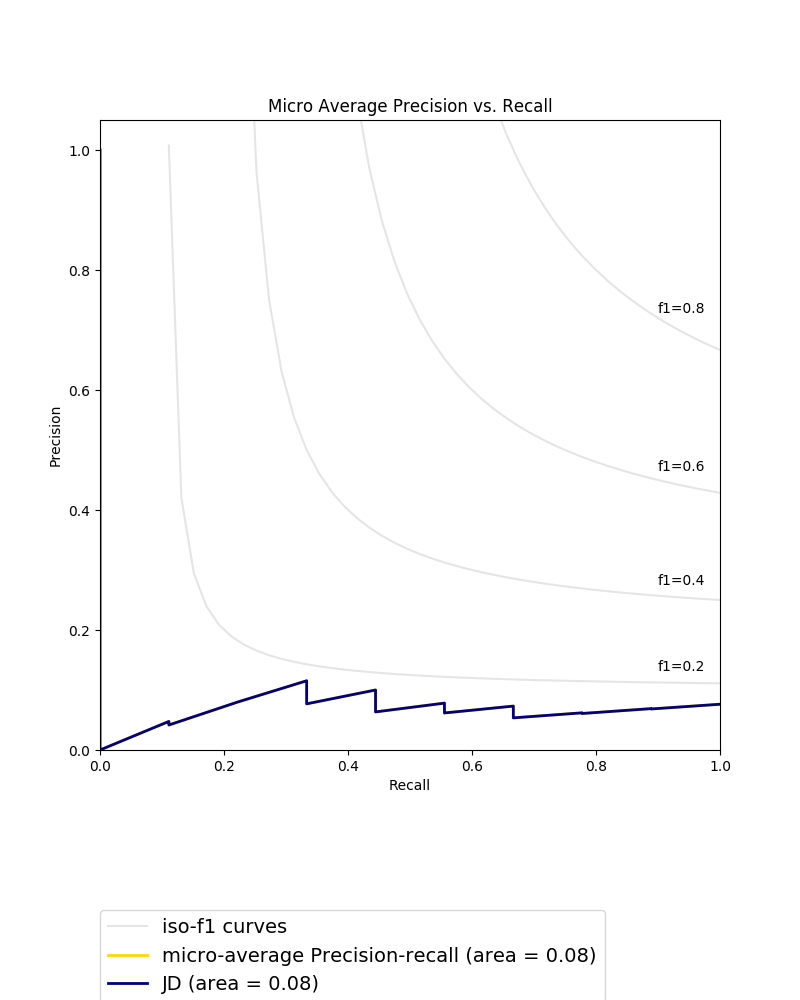

In [17]:
exp.display_performance(*exp.evaluate_model(test_data, thresh=0.5))

In [ ]:
raise Exception("Stop run all")

In [ ]:
if history_data:
    with open(os.path.join(search_output_dir, "history-{:d}epoch.pkl".format(num_epochs_train)), "wb") as file:
        pickle.dump({key: history.history for key, history in history_data.items()}, file)

In [ ]:
# #### Should you need to load this pkl:
# # with open(os.path.join(search_output_dir, "history-100epoch.pkl"), "rb") as file:
# #     history = pickle.load(file)

# lrs = [key[1] for key, val  in sorted(history_data.items(), key=lambda x: x[0])]
# val_loss = [history.history['val_loss'][-1] for key, history  in sorted(history_data.items(), key=lambda x: x[0])]
# loss = [history.history['loss'][-1] for lr, history  in sorted(history_data.items(), key=lambda x: x[0])]
# acc = [history.history['binary_accuracy'][-1] for lr, history  in sorted(history_data.items(), key=lambda x: x[0])]
# val_acc = [history.history['val_binary_accuracy'][-1] for lr, history  in sorted(history_data.items(), key=lambda x: x[0])]

# plt.figure()
# plt.subplot(1, 2, 1)
# plt.semilogx(lrs, loss, '.b', label='loss')
# plt.semilogx(lrs, val_loss, '.r', label='val_loss')
# plt.legend()
# plt.title("Loss Vs. LR (100 Epoch)")
# plt.subplot(1, 2, 2)
# plt.semilogx(lrs, acc, '.b', label='binary_accuracy')
# plt.semilogx(lrs, val_acc, '.r', label='val_binary_accuracy')
# plt.legend()
# plt.title("Accuracy Vs. LR (100 Epoch)")
# plt.tight_layout()

In [ ]:
log_dir = "/data/log/cnn/fd/large-fromCF/thursday/ID:3379 DS:alltogether-unique BS:7 AC:sigmoid MO:InceptionV3 HE:0x0 TR:all FT:imagenet LF:binary_crossentropy LR:2.7e-05 AR:1.8e-05 KR:3.1e-05 DO:0.00 PO:avg CW:0=3.05,1=0.54,2=1.02,3=0.54,4=4.57,5=0.76,6=2.29 method:plateau"
exp.model_def_path = os.path.join(log_dir, "model_def.json")
exp.model_weights_path = os.path.join(log_dir, "model_weights.h5")
exp.model_info_path = os.path.join(log_dir, "model.json")
exp.model_plot_path = os.path.join(log_dir, "precision-recall.png")

In [ ]:
# model_instance = "ID:3379 DS:alltogether-unique BS:7 AC:sigmoid MO:InceptionV3 HE:0x0 TR:all FT:imagenet LF:binary_crossentropy LR:2.7e-05 AR:1.8e-05 KR:3.1e-05 DO:0.00 PO:avg CW:0=3.05,1=0.54,2=1.02,3=0.54,4=4.57,5=0.76,6=2.29 method:plateau"
# exp = Experiment(dataset_name, image_dims)
# exp.deserialize(model_instance)
# exp.make_model(parallel=True)
# exp.get_train_model().load_weights("/data/log/cnn/fd/large-fromCF/thursday/ID:3379 DS:alltogether-unique BS:7 AC:sigmoid MO:InceptionV3 HE:0x0 TR:all FT:imagenet LF:binary_crossentropy LR:2.7e-05 AR:1.8e-05 KR:3.1e-05 DO:0.00 PO:avg CW:0=3.05,1=0.54,2=1.02,3=0.54,4=4.57,5=0.76,6=2.29 method:plateau/models/best.040-0.2809.h5")
# # exp.id = "3379"
# exp.set_logdir(os.path.join(search_output_dir, 'fritatta'))
exp.display_performance(*exp.evaluate_model(test_data, thresh=0.5))
# exp.history = dict()
# exp.save_model(
#     caption_map_r,
#     prediction_type=caption_type, test_metrics=None, description="Test model for 5 FDs")

# Continue training specific model

In [ ]:
model = None
K.clear_session()
search_output_dir = "/data/log/cnn/fd/large-fromCF/thursday" # Change this output dir.
model_instance = "ID:3379 DS:alltogether-unique BS:7 AC:sigmoid MO:InceptionV3 HE:0x0 TR:all FT:imagenet LF:binary_crossentropy LR:2.7e-05 AR:1.8e-05 KR:3.1e-05 DO:0.00 PO:avg CW:0=3.05,1=0.54,2=1.02,3=0.54,4=4.57,5=0.76,6=2.29 method:plateau"
model_best_weight = "model_weights.h5"

### Don't set below
exp = Experiment(dataset_name, image_dims)
exp.deserialize(model_instance)
exp.id = "{:d}".format(np.random.randint(0,999))
exp.dropout = 0.5

experiment_name = exp.serialize()

model_weights_in_path = os.path.join(search_output_dir, model_instance, model_best_weight)
log_dir = os.path.join(search_output_dir, model_instance, "continued", experiment_name)
best_path = os.path.join(log_dir, "models/best.{epoch:03d}-{val_loss:.4f}.h5")
model_def_path = os.path.join(log_dir, "model_def.json")
model_info_path = os.path.join(log_dir, "model.json")
model_plot_path = os.path.join(log_dir, "precision-recall.png")

print(model_weights_in_path)
if os.path.exists(model_weights_in_path):
    !mkdir -p "$log_dir/models"
else:
    raise OSError("path does not exist")
    
print("loading")
print(os.path.join(search_output_dir, model_instance, "model.json"))
exp.model = Inference(os.path.join(search_output_dir, model_instance, "model.json")).model
# base_model = p.feature_extractor(
#     include_top=False, weights=p.pretrained_weights, input_shape=image_dims)
# model = create_new_head(
#     base_model, p.num_classes, p.caption_type, p, 
#     opt_params={'optimizer': 'nadam'}
# )
exp.model.load_weights(model_weights_in_path)
# model = add_model_regularization(model, params.kernel_regularizer_l2, params.activity_regularizer_l1)

# for layer in model.layers:
#     layer.trainable = True

exp.model.compile( # TODO, load this from JSON, manually change this if you are doing single label
    'nadam',
    loss=exp.loss,
    metrics=['binary_accuracy', 'categorical_accuracy'])

print(experiment_name)
print(log_dir)
print("Training: {:d} layers".format(len([1 for layer in exp.model.layers if layer.trainable])))

In [ ]:
initial_epoch = 2
num_epoch = 200 # cumulative with initial_epoch
class_weights = None # Can't currently resume training with imbalance data #TODO
new_learning_rate = 5e-5
### Pick one schedule
schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=3, cooldown=0, verbose=1)
# schedule = lambda epoch, lr: lr_schedule_exp(epoch, base_lr=5e-5, gamma=0.98) # Exponential decay
# schedule = None


#### Don't set below

K.set_value(exp.model.optimizer.lr, new_learning_rate)
callbacks = setup_callbacks(log_dir, schedule=schedule, hist=2, grads=True)
history_data[experiment_name] = go(exp.model, callbacks, num_epoch, exp.class_weights, initial_epoch=initial_epoch)

(Y_true, Y_pred, TP) = evaluate_model(exp.model, test_data, thresh=0.5)
display_performance(Y_true, Y_pred, TP)

save_model(
    exp.model, name=experiment_name,
    class_map_r=caption_map_r, prediction_type=caption_type,
    model_weights_path=model_weights_path, model_def_path=model_def_path, model_info_path=model_info_path,
    test_metrics=None, history=history_data[experiment_name],
    description="Test model for 5 FDs"
)

In [ ]:
del exp

# LR Search

In [ ]:
class LrSearch():
    def __init__(self, instance_str):
        self.model_init_w = None
        self.model_instance = instance_str
        self.exp = None
        self.history = {}
        
    def new_model(self):
        K.clear_session()
        self.exp = Experiment(dataset_name, image_dims)
        self.exp.deserialize(self.model_instance)
        self.exp.make_model(self.model_init_w, parallel=True)
        self.exp.compile_model()
#         self.exp.setup_callbacks(schedule=init_schedule(), hist=0)
        print("Trainable layers: {:d}".format(sum([layer.trainable for layer in self.exp.model.layers])))
        if self.model_init_w is None:
            self.model_init_w = self.exp.model.get_weights()
        
        
    def go(self, epochs, num_steps=10, lr_range=(-9, 0)):
        for base_lr in 10 ** np.random.uniform(*lr_range, size=num_steps):
            print("Learning rate = {:.3e}".format(base_lr))
            self.new_model()
            K.set_value(self.exp.get_train_model().optimizer.lr, base_lr)
            self.history[base_lr] = self.exp.go(epochs)
        return self.history
    
    def plot(self):
        df = []
        for lr, h in self.history.items():
            metrics = np.vstack([np.array(h.history['binary_accuracy']), np.array(h.history['loss'])])
            diff = (metrics[:, -1] - metrics[:, 0])[np.newaxis]
            metrics = np.vstack([metrics[:, -1], diff]).ravel()
            metrics = np.array([lr] + metrics.tolist())
            dfh = pd.DataFrame(
                    data=pd.Series(
                        data=metrics,
                        index=['lr', 'binary_accuracy', 'loss', 'diff_acc', 'diff_loss'])
                ).T.set_index('lr')
            df.append(dfh)
        df = pd.concat(df).sort_index()
        df.plot(logx=True)

In [ ]:
del exp

In [ ]:
model_instance = "ID:5740 DS:alltogether BS:4 AC:sigmoid MO:VGG16 HE:0x64 TR:all FT:imagenet LF:binary_crossentropy LR:5.1e-04 AR:1.0e-06 KR:1.0e-06 DO:0.00 PO:avg CW:0=4.26,1=0.64,2=0.49,3=7.11 method:plateau"
search = LrSearch(model_instance)
# Hexpo: 4.5e-4 (1e-4 to 6e-4)
# VGG Heads only: 4.4e-5 to 2e-2
# VGG Imagenet: 2e-5

In [ ]:
search.go(5, num_steps=4, lr_range=(-6, -4))
search.plot()
# del search

In [ ]:
del search

# Below is untested with new changes, don't use

In [ ]:
# def get_gradients(model):
#     """Get the gradients of the loss with respect to the weights."""
#     weights = [tensor for tensor in model.trainable_weights 
#                if model.trainable_weights]
#     return weights, model.optimizer.get_gradients(model.total_loss, weights)

        
# def hamming_loss(y_true, y_pred):
#     return K.mean(y_true * (1 - y_pred) + (1 - y_true) * y_pred)


# def check_gradients(model):
#     grad_test = None
#     for image, label in train_gen:
#         grad_test = (image, label)
#         break
#     rates = []
#     weights, grads = get_gradients(model)
#     feed_dict = {
#         "class_logits_sample_weights:0": np.ones(2),
#         "input_1:0": grad_test[0][np.newaxis, ...],
#         "class_logits_target:0": grad_test[1][np.newaxis, ...]
#     }
#     for i, (w, g) in enumerate(zip(weights, grads)):
#         if 'bias' in w.name:
#             continue
#         grad_norm = np.linalg.norm(g.eval(feed_dict, K.get_session()))
#         weight_norm = np.linalg.norm(w.eval(K.get_session()))
#         rate = grad_norm / weight_norm
#         rates.append(rate)
#     if np.mean(rates) < 5e-4 or np.mean(rates) > 3e-1: # These values change with network structure
#         print("Bad gradients ({:.3e}).".format(np.mean(rates)))
#         return False
#     return True

In [ ]:
# layer=model.layers[-3]
# print(layer)
# for weight in layer.weights:
#     weight.initializer.run(session=K.get_session())
# # w = layer.get_weights()
# # plt.figure()
# # plt.hist(w[0].ravel(), bins=100)

In [ ]:
# # More training
# K.set_value(model.optimizer.lr, 1e-4)

# go(300, class_weights, initial_epoch=200)
# (Y_true, Y_pred, TP) = evaluate_model(model, test_data, thresh=0.5)
# display_performance(Y_true, Y_pred, TP)

# # save_model(
# #     model, name=experiment_name + "-second",
# #     class_map_r=caption_map_r, prediction_type=caption_type,
# #     model_weights_path=model_weights_path, model_def_path=model_def_path, model_info_path=model_info_path,
# #     test_metrics=None, history=history_data[experiment_name],
# #     description="Test model for 5 FDs"
# # )

# Model Testing

In [ ]:
from herbicide.utils import vis_square
TP_mask = np.logical_and.reduce(TP, axis=1)
right = test_data[0][TP_mask]
wrong = test_data[0][~TP_mask]
wrong.shape
plt.figure()
vis_square(wrong)
plt.title("Incorrectly Predicted")
plt.figure()
vis_square(right)
plt.title("Correctly Predicted")

# Binary coded the labels then count them wrt TP/FP
print("num labels", test_data[1].sum(axis=0))
coded = np.sum(test_data[1][~TP_mask] * 2 ** np.arange(num_classes)[::-1], axis=1).astype(int)
print("binary coded class error count:", dict(sorted(Counter(coded).items(), key=lambda x: x[0])))
coded = np.sum(test_data[1][TP_mask] * 2 ** np.arange(num_classes)[::-1], axis=1).astype(int)
print("binary coded class correct count:", dict(sorted(Counter(coded).items(), key=lambda x: x[0])))
print(Y_pred[TP_mask])

# Learning Curve

In [ ]:
# def learning_curve(dataset, lr, steps, val_data, log_dir):
#     def save_model(path):
#         print("Saving", path)
#         os.makedirs(os.path.dirname(path), exist_ok=True)
#         model.save_weights(path)
#     def setup_callbacks():
#         return [
# #                 ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, cooldown=5, verbose=1),
# #                 ModelCheckpoint(
# #                     model_best_path, monitor='val_loss', verbose=1,
# #                     save_best_only=True, save_weights_only=True, mode='auto', period=1),
# #                 ModelCheckpoint(
# #                     best_path, monitor='val_loss', verbose=1,
# #                     save_best_only=False, save_weights_only=True, mode='auto', period=50),
#                 PRTensorBoard(
#                     log_dir=model_log_dir,
#                     histogram_freq=0,
#                     batch_size=batch_size,
#                     write_graph=False,
#                     write_grads=False,
#                     write_images=False),
#         #         EarlyStopping(
#         #             monitor='val_loss', min_delta=0.0, patience=40, verbose=1, mode='auto')
#         ]
#     def create_new_model(load_base=False):
#         clear_session()
#         model = create_new_head(
#             InceptionV3(include_top=False, weights='imagenet', input_shape=image_dims),
#             num_classes, caption_type, opt_params={'optimizer': Nadam()},
#             class_weights=None, train_features=False, l2_reg=None)
#         if load_base:
#             print("Loading base model")
#             model.load_weights(base_model_path, by_name=True)
#         return model

#     def train():
#         print("Training")
#         K.set_value(model.optimizer.lr, lr)
#         history[subset_size] = model.fit_generator(
#             batching_gen(gen, batch_size=batch_size),
#             validation_data=tuple(val_data),
#             steps_per_epoch=(subset_size // batch_size),
#             validation_steps=steps_per_epoch_val,
#             class_weight=model_class_weights,
#             callbacks=setup_callbacks(), 
#             epochs=50,
#             verbose=1)
#     model_class_weights = None
#     model = None
#     model_path = None
#     image_ids = [image['id'] for image in dataset.imgs.values()]
#     np.random.shuffle(image_ids)
#     num_images = len(image_ids)
#     print("num_images", num_images)
#     history = {}
#     base_model_path = os.path.join(log_dir, "base", "weights.h5")
#     model_path = base_model_path
#     for subset_size in np.linspace(0, num_images, steps + 1).astype(int):
#         if subset_size > 0:
#             imgIds = image_ids[:subset_size]
#             gen = pipeline(
#                 dataset.generator(shuffle_ids=False, imgIds=imgIds),
#                 aug_config=None)
#             model_class_weights = calc_class_weights(gen, dataset) # TODO

#             model_path = os.path.join(log_dir, "subset-of-{:d}/weights.h5".format(subset_size))
#             model_log_dir = os.path.dirname(model_path)
#             model_best_path = os.path.join(log_dir, "subset-of-{:d}/best.h5".format(subset_size))
#             os.makedirs(model_log_dir, exist_ok=True)

#             print("learning curve(lr={:.3e}, size={:d})".format(lr, subset_size))
#             print("model_log_dir", model_log_dir)
#             print("training class weights")
#             print(model_class_weights)
#         model = create_new_model(load_base=(subset_size > 0))
#         if subset_size:
#             train()
#         save_model(model_path)
#     return history

# model = None
# lr = 1e-5
# learning_curve_dir = "/data/log/cnn/fd/learning_curve_5--{:.2e}".format(lr)
# lc_history = learning_curve(coco_train, lr, 5, val_data, learning_curve_dir)
# val_loss = np.array([(size, h.history['val_loss'][-1]) for size, h in lc_history.items()])
# train_loss = np.array([(size, h.history['loss'][-1]) for size, h in lc_history.items()])
# plt.figure()
# plt.plot(train_loss[:, 0], train_loss[:, 1], 'b.')
# plt.plot(val_loss[:, 0], val_loss[:, 1], 'r.')
# plt.xlabel("Number of Training Samples")
# plt.ylabel("Loss")
# plt.savefig(os.path.join(learning_curve_dir, "plot.png"), dpi=150)

In [ ]:
# !rm -R /data/log/cnn/fd/learning-curve/

In [ ]:
# images = None
# for images, labels in batching_gen(train_gen, batch_size=batch_size):
#     print(images.shape, labels.shape)
    
#     pred = model.predict(images)
#     print(labels)
#     print(pred)
#     print(K.eval(K.tf.losses.sigmoid_cross_entropy(labels, pred)))
#     break

In [ ]:
# for unique_label in np.unique(val_data[1], axis=0):
#     unique_data = [val_data[0][i] for i in range(len(val_data[0])) if np.all(val_data[1][i] == unique_label)]
#     num_data = len(unique_data)
#     print(unique_label, num_data)
#     plt.figure()
#     vis_square(np.array(unique_data))
#     plt.title(unique_label)

# Check Update/Weight Ratio

In [ ]:

# for i, (w, g) in enumerate(zip(weights, grads)):
#     grad_norm = np.linalg.norm(g.eval(feed_dict, K.get_session()))
#     weight_norm = np.linalg.norm(w.eval(K.get_session()))
#     rate = grad_norm / weight_norm
#     print(i, rate)


# Visualize filters

In [ ]:
from herbicide.utils import vis_square
for layer in model.layers:
    if not layer.trainable_weights:
        continue
    for weight in layer.trainable_weights: #  Assumes FD is not trainable
        if 'kernel' not in weight.name:
            continue
        print(weight.name)
        value = K.eval(weight.value())
        print(value.shape)
    
    plt.figure()
    vis_square(value.transpose((3, 0, 1, 2)))
    break


In [ ]:
caption_stats = []
for i, (image, caption) in enumerate(coco_train.generator(imgIds=balanced_image_ids_train)):
    plt.figure()
    plt.imshow(image)
    plt.title(str(caption))
    if i == 10:
        break
    caption_stats.append(caption)